In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import os
import re
import matplotlib.pyplot as plt
from collections import defaultdict

## EDA

Segmented folder has black background (and maybe some light balancing)

In [3]:
# get the tomato imgs from Kaggle
seg_imgs = glob.glob('/kaggle/input/plantvillage-dataset/segmented/Tomato*/*.jpg')

# how many files with which resolution
img_res = defaultdict(int)
for f in seg_imgs:
    im_shape = plt.imread(f).shape
    if im_shape!=(256, 256, 3): print(f)
    img_res[plt.imread(f).shape] += 1
    
print('Nbr of images:', len(seg_imgs))
print('Resolution')
for shp in img_res:
    print(shp, img_res[shp])

/kaggle/input/plantvillage-dataset/segmented/Tomato___Spider_mites Two-spotted_spider_mite/Com.G_SpM_FL 1378_final_masked.jpg
Nbr of images: 18160
Resolution
(256, 256, 3) 18159
(512, 335, 3) 1


In [5]:
seg_imgs.remove('/kaggle/input/plantvillage-dataset/segmented/Tomato___Spider_mites Two-spotted_spider_mite/Com.G_SpM_FL 1378_final_masked.jpg')

In [7]:
len(seg_imgs)

18159

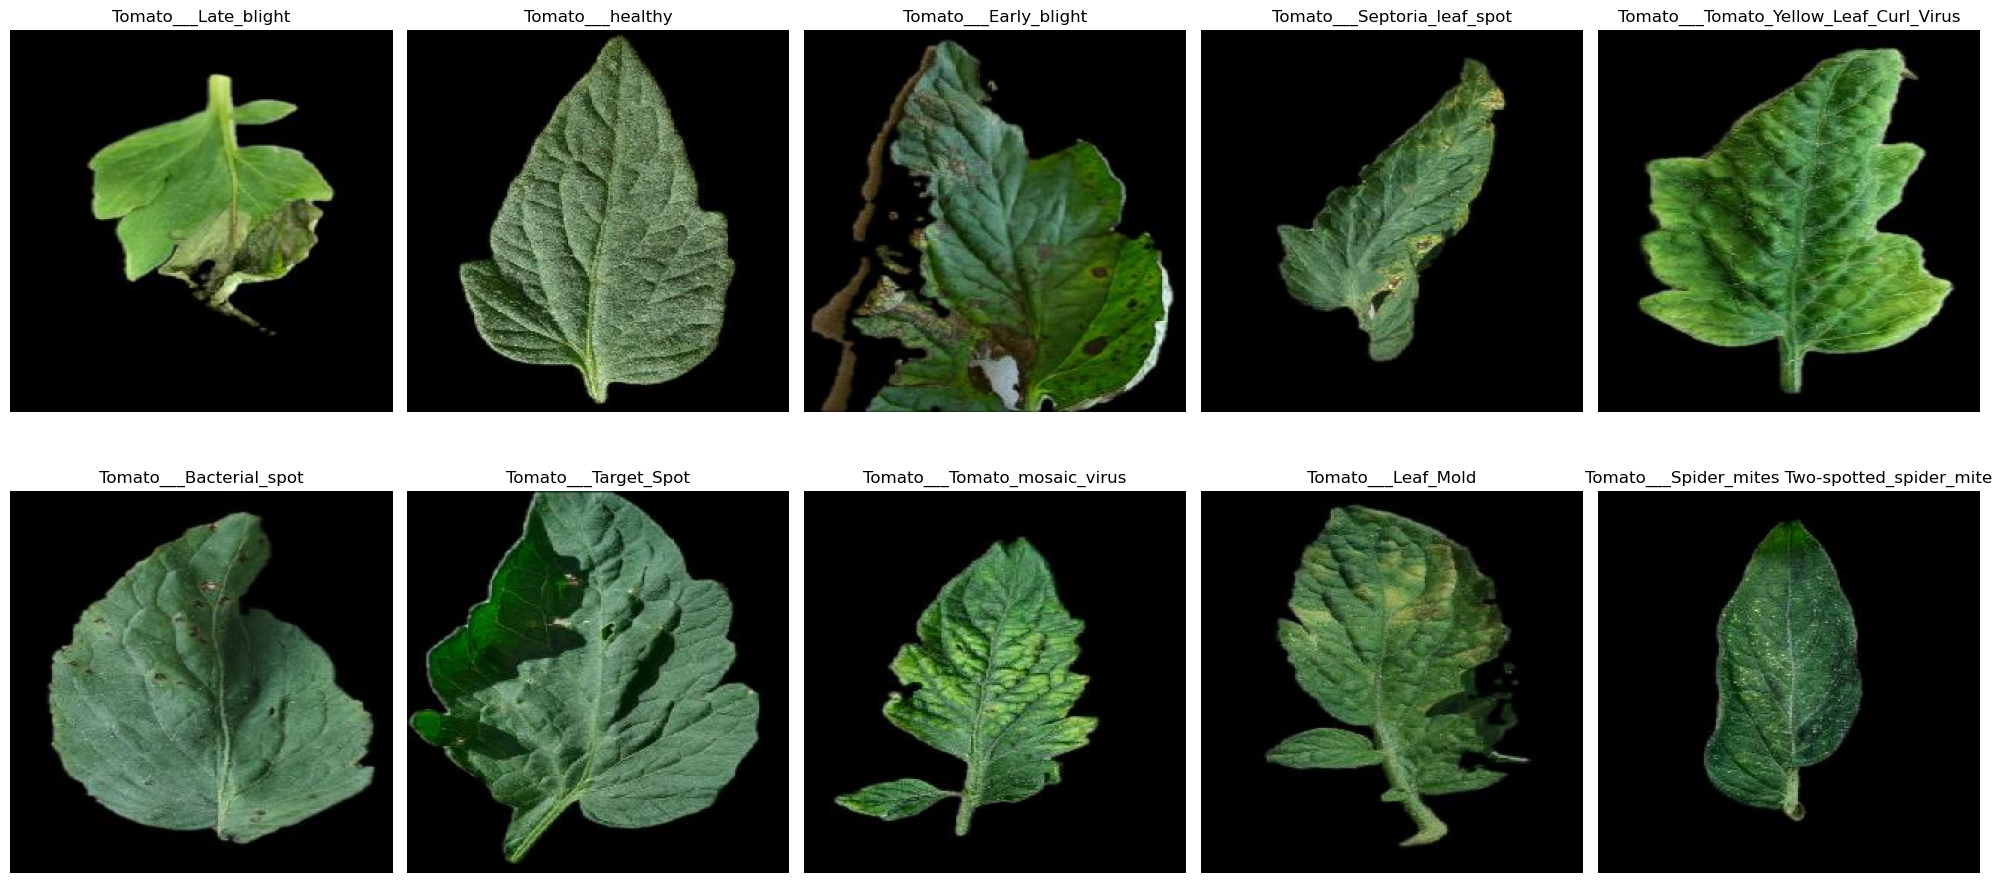

In [58]:
### viz some images

# get one image per category
df_seg = pd.DataFrame(seg_files, columns=['fpath'])
df_seg['category'] = df_seg['fpath'].str.split('/').str[5]
df_seg_to_plot = df_seg.drop_duplicates(subset='category').reset_index(drop=True)

# create plot
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
for i,d in enumerate(df_seg_to_plot.to_dict('records')):
    j = 0 if i<5 else 1
    i = i%5
    ax[j, i].imshow(plt.imread(d['fpath']))
    ax[j, i].axis('off')
    ax[j, i].set_title(f'{d["category"]}')
plt.tight_layout()
plt.show()

Color folder has original background

In [64]:
# get the tomato imgs from Kaggle
col_imgs = glob.glob('/kaggle/input/plantvillage-dataset/color/Tomato*/*.JPG') + glob.glob('/kaggle/input/plantvillage-dataset/color/Tomato*/*.jpg')

# how many files with which resolution
img_res = defaultdict(int)
for f in col_imgs:
    img_res[plt.imread(f).shape] += 1
    
print('Nbr of images:', len(col_imgs))
print('Resolution')
for shp in img_res:
    print(shp, img_res[shp])

Nbr of images: 18159
Resolution
(256, 256, 3) 18159


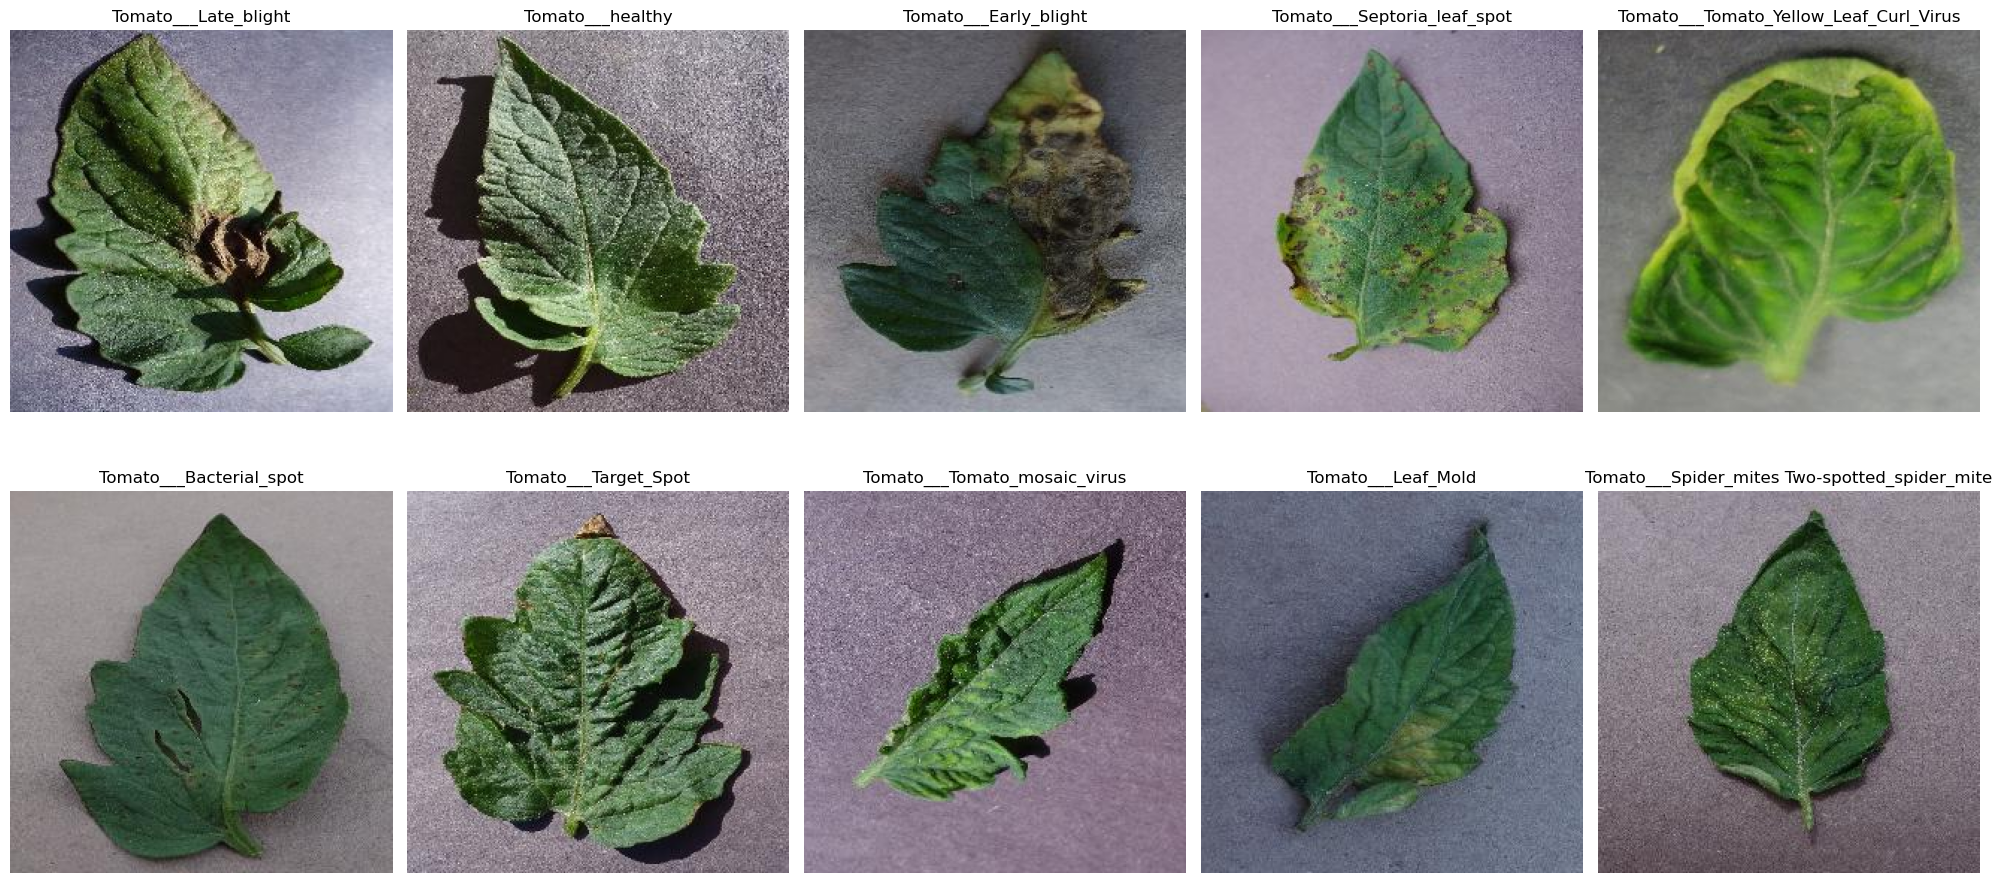

In [67]:
### viz some images

# get one image per category
df_col = pd.DataFrame(col_imgs, columns=['fpath'])
df_col['category'] = df_col['fpath'].str.split('/').str[5]
df_col_to_plot = df_col.drop_duplicates(subset='category').reset_index(drop=True)

# create plot
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
for i,d in enumerate(df_col_to_plot.to_dict('records')):
    j = 0 if i<5 else 1
    i = i%5
    ax[j, i].imshow(plt.imread(d['fpath']))
    ax[j, i].axis('off')
    ax[j, i].set_title(f'{d["category"]}')
plt.tight_layout()
plt.show()

## CNN model (pytorch)

In [2]:
import pandas as pd
import numpy as np
import glob
import os
import re
import matplotlib.pyplot as plt
import time

import torch
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F
import torchvision
from torchvision.io import read_image, ImageReadMode
from torch.utils.data import Dataset, DataLoader

Dataset to read data as needed from memory

In [3]:
class PlantDatasetIM(Dataset):
    """Load dataset in memory"""
    def __init__(self):
        self.im_paths = glob.glob('/kaggle/input/plantvillage-dataset/segmented/Tomato*/*.jpg') + glob.glob('/kaggle/input/plantvillage-dataset/segmented/Tomato*/*.JPG')
        img_arr_list, lbl_list = [], []
        for im_path in self.im_paths:
            # labels
            lbl = im_path.split('/')[5]
            lbl_list.append(self._clean_lbl(lbl))
            # image array: torch expects it as (C, H, W)
            im = plt.imread(im_path)
            if im.shape != (256, 256, 3):
                continue
            im = im.astype(np.float32) / 255
            img_arr_list.append(im.reshape(3, 256, 256))
        
        # concatenate all images for final dataset (B, C, H, W)
        self.dset = np.stack(img_arr_list)
        # labels
        self.lbl_cat_lkp = {e: float(i) for i,e in enumerate(set(lbl_list))}
        self.lbl_str = lbl_list
        self.cat = [self.lbl_cat_lkp[e] for e in self.lbl_str]
    
    def __getitem__(self, idx):
        return self.dset[idx], self.cat[idx]
    
    def __len__(self):
        return self.dset.shape[0]
    
    def _clean_lbl(lbl):
        lbl = lbl.lower()
        return re.search(r'tomato___(?:tomato_)?(\w+)', lbl).group(1)
    

class PlantDataset(Dataset):
    """Load images as needed"""
    def __init__(self):
        # store image list from disk
        self.im_paths = glob.glob('/kaggle/input/plantvillage-dataset/segmented/Tomato*/*.jpg') + glob.glob('/kaggle/input/plantvillage-dataset/segmented/Tomato*/*.JPG')
        self.im_paths.remove('/kaggle/input/plantvillage-dataset/segmented/Tomato___Spider_mites Two-spotted_spider_mite/Com.G_SpM_FL 1378_final_masked.jpg') # img with different resolution
        # store the labels and create lookup for easy retrieval
        self.lbl_list = [self._clean_lbl(im_path.split('/')[5]) for im_path in self.im_paths]
        self.lbl_cat_lkp = {e: i for i,e in enumerate(set(self.lbl_list))}
        self.cat = [self.lbl_cat_lkp[e] for e in self.lbl_list]
    
    def __getitem__(self, idx):
        """Return processed image from file list"""
        im_path = self.im_paths[idx]
        tim = read_image(im_path, ImageReadMode.RGB)
        return tim/255, self.cat[idx]
    
    def __len__(self):
        return len(self.im_paths)
    
    def _clean_lbl(self, lbl):
        lbl = lbl.lower()
        return re.search(r'tomato___(?:tomato_)?(\w+)', lbl).group(1)

Define the model and training loop

In [19]:
class ConvNet(nn.Module):
    """Basic CNN to classify the plants"""
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 8, kernel_size=5)
        self.pool2 = nn.MaxPool2d(2)
        self.flat = nn.Flatten()
        self.lin1 = nn.Linear(8*61*61, 64)
        self.lin2 = nn.Linear(64, 10)
        
    def forward(self, x):
        out = F.relu(self.pool1(self.conv1(x)))
        out = F.relu(self.pool2(self.conv2(out)))
        out = self.flat(out)
        out = F.relu(self.lin1(out))
        return self.lin2(out)
    
    def pred_probas(self, data_loader):
        preds = []
        with torch.no_grad():
            for imgs, labels in data_loader:
                imgs = imgs.to(device)
                labels = labels.to(device)
                output = model(imgs)
                preds.append(output.cpu().detach().numpy())
        return np.concatenate(preds)

    def preds(self, data_loader):
        preds = []
        with torch.no_grad():
            for imgs, labels in data_loader:
                imgs = imgs.to(device)
                labels = labels.to(device)
                output = model(imgs)
                _, predicted = torch.max(output, dim=1)
                preds.append(predicted.cpu().detach().numpy())
        return np.concatenate(preds)

    
def training_loop(n_epochs, model, optimizer, loss_fn, data_loader, device):
    """Run training loop"""
    print(f'Starting training loop (running on {device})')
    losses = []
    for epoch in range(1, n_epochs+1):
        total_loss = 0.
        start = time.time()
        for imgs, labels in data_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            model_output = model(imgs)
            loss = loss_fn(model_output, labels)
            
            # clean the grad
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # get the loss
            total_loss += loss.item()
        losses.append(total_loss/len(data_loader))
        
        # print for viz
        if epoch==1 or epoch%1==0:
            end = time.time()
            print(f'Epoch {epoch} loss: {total_loss/len(data_loader):.3f} ({end-start:.1f}s)')
            
    return losses


def model_accuracy(model, data_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            output = model(imgs)
            _, predicted = torch.max(output, dim=1)
            total += labels.shape[0]
            correct += int((predicted==labels).sum())
            print(predicted.to('cpu').numpy())
    return correct/total
    
# check that model runs ok
# mod = ConvNet()
# print(mod.forward(p_dset[0][0].unsqueeze(0)))
# print(mod)


In [58]:
#---- Load data
plant_dset = PlantDataset()
plant_dloader = DataLoader(plant_dset, batch_size=64, shuffle=True)
print(f'Total images: {len(plant_dset):,}')

Total images: 18,159


Starting training loop. Running on cuda
Epoch 1 loss: 1.290 (58.8s)
Epoch 2 loss: 0.774 (55.4s)
Epoch 3 loss: 0.585 (55.6s)
Epoch 4 loss: 0.471 (55.2s)
Epoch 5 loss: 0.370 (54.4s)


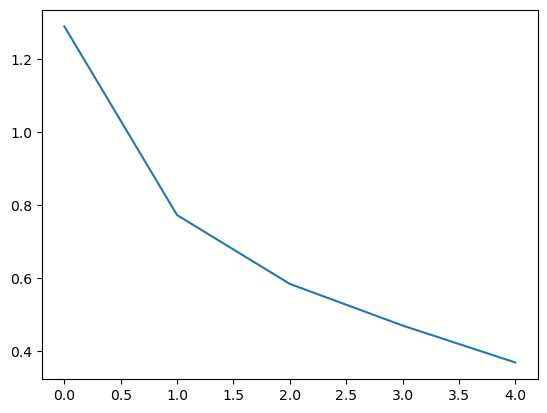

In [21]:
#----- Train model

# build model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ConvNet().to(device)

# run training loop
optimizer = Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

losses = training_loop(
    n_epochs=5,
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    data_loader=plant_dloader,
    device=device
)
plt.plot(losses)
plt.show()

In [28]:
preds = model.preds(DataLoader(plant_dset, batch_size=64, shuffle=False))

In [34]:
from sklearn.metrics import classification_report

print(classification_report(preds, plant_dset.cat))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      2179
           1       0.97      0.89      0.93      1724
           2       0.92      0.82      0.87      1077
           3       0.98      0.99      0.98      5299
           4       0.74      0.90      0.81       823
           5       0.83      0.94      0.88      1565
           6       0.91      0.82      0.86      1564
           7       0.89      0.94      0.91      1579
           8       0.82      0.98      0.89       312
           9       0.95      0.89      0.92      2037

    accuracy                           0.93     18159
   macro avg       0.90      0.91      0.90     18159
weighted avg       0.93      0.93      0.93     18159



<Axes: >

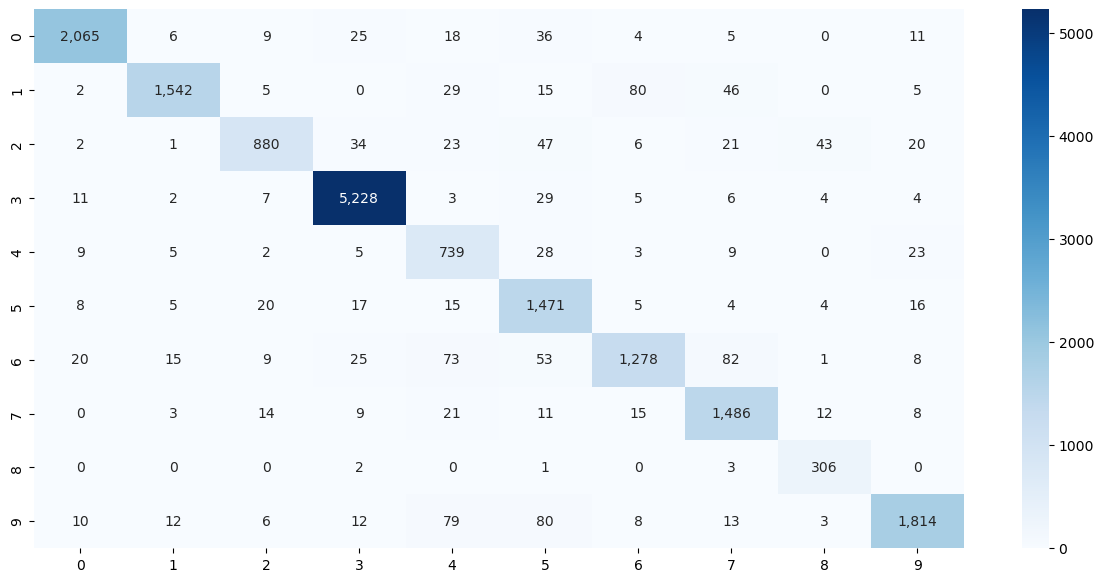

In [54]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(1, 1, figsize=(15, 7))
sns.heatmap(confusion_matrix(preds, plant_dset.cat), annot=True, fmt=',.0f', cmap='Blues', ax=ax)

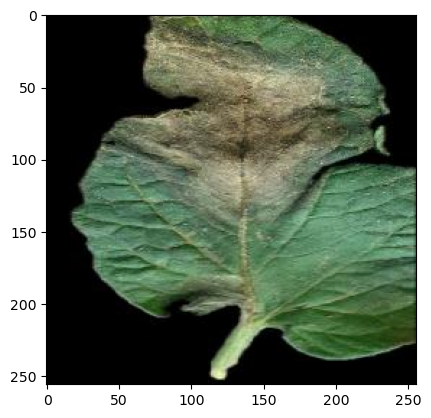

In [17]:
# to viz an image from the dataset directly we need to change the order of the channels
plt.imshow(p_dset[0][0].permute(1, 2, 0))

In [61]:
!nvidia-smi

Sun Jul  2 15:48:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    33W / 250W |   2931MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------